In [1]:
import sys


sys.path.append("../src/")

In [2]:
from sennet.custom_modules.metrics.surface_dice_metric_fast import create_table_neighbour_code_to_surface_area
import torch
import matplotlib.pyplot as plt
import numpy as np

In [3]:
device = "cpu"


unfold = torch.nn.Unfold(kernel_size=(2, 2), padding=1)


area = create_table_neighbour_code_to_surface_area((1, 1, 1))
area = torch.from_numpy(area).to(device)  # torch.float32
area.shape

torch.Size([256])

bases_vals.shape=(256, 8)
bases.shape=torch.Size([256, 8])


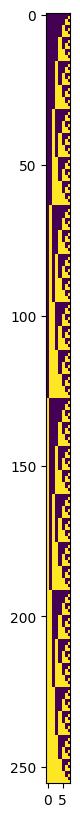

In [4]:
bases_vals = np.array([
    [c=="1" for c in f"{i:08b}"]
    for i in range(256)
])  #.transpose()
bases = torch.from_numpy(bases_vals).float().to(device)
print(f"{bases_vals.shape=}")
print(f"{bases.shape=}")

plt.figure(figsize=(20, 10))
plt.imshow(bases_vals)

In [5]:
batch_size = 1
zs = 2
ys = 3
xs = 3

pred = torch.rand((batch_size, zs, ys, xs)).to(device)
labels = (torch.rand((batch_size, zs, ys, xs)) > 0.5).to(device)

# pred = labels.float()   # sanity check to see if loss will be 0

In [6]:
unfolded_pred = unfold(pred)
unfolded_labels = unfold(labels.float())

# permuted_unfolded_pred = unfolded_pred.permute((0, 2, 1)).unsqueeze(-1)
# permuted_unfolded_labels = unfolded_labels.permute((0, 2, 1)).unsqueeze(-1)

print(f"{unfolded_pred.shape=}")
print(f"{unfolded_labels.shape=}")
# print(f"{permuted_unfolded_pred.shape=}")
# print(f"{permuted_unfolded_labels.shape=}")

unfolded_pred.shape=torch.Size([1, 8, 16])
unfolded_labels.shape=torch.Size([1, 8, 16])


## one greedy solver iter

In [7]:
# greedy solver
batch_size, n_corners, n_points = unfolded_pred.shape
assert n_corners == 8, f"{n_corners=} == 8, are you working on 2 slices?"
weights = torch.zeros((batch_size, 256, n_points))

copied_unfolded_pred = unfolded_pred.clone()
done = (copied_unfolded_pred.abs() < 1e-5).all()
nonzero_masks = copied_unfolded_pred > 0
pred_min_vals = torch.zeros((batch_size, n_points), device=device, dtype=torch.float32)
has_cube = torch.any(nonzero_masks, dim=1)

pred_cube_bytes = sum(nonzero_masks[:, k, :] << (7-k) for k in range(8))
pred_cube_bases = bases[pred_cube_bytes, :].permute((0, 2, 1))
subtraction_weights = torch.where(copied_unfolded_pred > 0, copied_unfolded_pred, torch.inf).min(1).values  # (batch, n_points)
subtraction_weights[subtraction_weights.isinf()] = 0

# weights[pred_cube_bytes] += subtraction_weights
# copied_unfolded_pred[b] -= w[None, :] * cube_bases

for b in range(batch_size):
    w = subtraction_weights[b]
    weights[b][pred_cube_bytes[b], list(range(weights.shape[2]))] += w
    copied_unfolded_pred[b] -= w[None, :] * pred_cube_bases[b]
    print(f"{w.shape = }")
    print(f"{w = }")
    print(f"{pred_cube_bytes[b] = }")
    print(f"{copied_unfolded_pred[b].shape = }")
    print("-----")

print(f"{unfolded_pred.shape = }")
print(f"{nonzero_masks.shape = }")
print(f"{pred_min_vals.shape = }")
print(f"{has_cube.shape = }")
print(f"{weights.shape = }")
print(f"{pred_cube_bases.shape = }")
print(f"{subtraction_weights.shape = }")
print(f"{done = }")
print(pred_cube_bytes)

w.shape = torch.Size([16])
w = tensor([0.0046, 0.0046, 0.2610, 0.8058, 0.0046, 0.0046, 0.2610, 0.8058, 0.0374,
        0.0374, 0.0814, 0.5043, 0.0374, 0.0374, 0.0814, 0.5043])
pred_cube_bytes[b] = tensor([ 17,  51,  51,  34,  85, 255, 255, 170,  85, 255, 255, 170,  68, 204,
        204, 136])
copied_unfolded_pred[b].shape = torch.Size([8, 16])
-----
unfolded_pred.shape = torch.Size([1, 8, 16])
nonzero_masks.shape = torch.Size([1, 8, 16])
pred_min_vals.shape = torch.Size([1, 16])
has_cube.shape = torch.Size([1, 16])
weights.shape = torch.Size([1, 256, 16])
pred_cube_bases.shape = torch.Size([1, 8, 16])
subtraction_weights.shape = torch.Size([1, 16])
done = tensor(False)
tensor([[ 17,  51,  51,  34,  85, 255, 255, 170,  85, 255, 255, 170,  68, 204,
         204, 136]])


## greedy solver until done

In [8]:
batch_size, n_corners, n_points = unfolded_pred.shape
assert n_corners == 8, f"{n_corners=} == 8, are you working on 2 slices?"
weights = torch.zeros((batch_size, 256, n_points))

copied_unfolded_pred = unfolded_pred.clone()
while True:
    done = (copied_unfolded_pred.abs() < 1e-5).all()
    if done:
        break

    nonzero_masks = copied_unfolded_pred > 0
    pred_min_vals = torch.zeros((batch_size, n_points), device=device, dtype=torch.float32)
    has_cube = torch.any(nonzero_masks, dim=1)
    
    pred_cube_bytes = sum(nonzero_masks[:, k, :] << (7-k) for k in range(8))
    pred_cube_bases = bases[pred_cube_bytes, :].permute((0, 2, 1))
    subtraction_weights = torch.where(copied_unfolded_pred > 0, copied_unfolded_pred, torch.inf).min(1).values  # (batch, n_points)
    subtraction_weights[subtraction_weights.isinf()] = 0
    
    for b in range(batch_size):
        w = subtraction_weights[b]
        weights[b][pred_cube_bytes[b], list(range(weights.shape[2]))] += w
        copied_unfolded_pred[b] -= w[None, :] * pred_cube_bases[b]

residual = (bases.permute((1, 0)).tile((batch_size, 1, 1)) @ weights) - unfolded_pred
assert residual.abs().sum() < 1e-5

## labels

In [9]:
label_cubes_byte = torch.zeros((unfolded_labels.shape[0], unfolded_labels.shape[2]), dtype=torch.int32, device=device)
for k in range(8):
    label_cubes_byte += unfolded_labels[:, k, :].to(torch.int32) << k


label_areas = torch.zeros((label_cubes_byte.shape[0], label_cubes_byte.shape[1]), dtype=torch.float32, device=device)
for b in range(label_cubes_byte.shape[0]):
    label_areas[b, :] = torch.where(label_cubes_byte[b, :] == 0, label_areas[b, :], area[label_cubes_byte[b, :] - 1])


print(f"{unfolded_labels.shape = }")
print(f"{label_cubes_byte.shape = }")
print(f"{label_areas.shape = }")

unfolded_labels.shape = torch.Size([1, 8, 16])
label_cubes_byte.shape = torch.Size([1, 16])
label_areas.shape = torch.Size([1, 16])


In [10]:
print(f"{bases.shape = }")
print(f"{weights.shape = }")
print(f"{unfolded_pred.shape = }")
print(f"{area.shape = }")

bases.shape = torch.Size([256, 8])
weights.shape = torch.Size([1, 256, 16])
unfolded_pred.shape = torch.Size([1, 8, 16])
area.shape = torch.Size([256])


In [16]:
pred_areas = (weights.permute((0, 2, 1)) @ area.tile((batch_size, 1)).unsqueeze(-1)).squeeze(-1)
pred_areas.shape

torch.Size([1, 16])

In [19]:
intersection = pred_areas * label_areas

In [20]:
smooth = 1e-3
numerator = 2 * intersection.sum()
denominator = label_areas.sum() + pred_areas.sum()
dice = 1 - ((numerator + smooth) / (denominator + smooth))

print(f"{dice = }")
print(f"{pred_areas.sum() = }")
print(f"{label_areas.sum() = }")
print(f"{intersection.sum() = }")

dice = tensor(0.3377)
pred_areas.sum() = tensor(9.5315)
label_areas.sum() = tensor(11.2411)
intersection.sum() = tensor(6.8789)


### sanity check for when pred == label, areas should equal

In [ ]:
squeezed_base_weights = bases_weights.squeeze(0).squeeze(-1)  # useful when batch size == 1
squeezed_permuted_unfolded_pred = permuted_unfolded_pred.squeeze(0).squeeze(-1)

print(f"{squeezed_base_weights.shape = }")
print(f"{squeezed_permuted_unfolded_pred.shape = }")
print(f"{bases.shape = }")

torch.abs(squeezed_base_weights @ bases.permute((1, 0)) - squeezed_permuted_unfolded_pred).sum()

In [ ]:
# check that computed pred cube matches label cubes

base_weights_max = squeezed_base_weights.max(1)
base_weights_max_vals = base_weights_max.values
base_weights_max_indices = base_weights_max.indices + 1

print(bases_weights.shape)
print()
print(f"pred_cube_byte: {base_weights_max_indices}")
print()
print(f"pred_cube_weights: {base_weights_max_vals}")
print()
print(f"label_cubes_byte: {label_cubes_byte}")

In [ ]:
label_areas.reshape(-1)

In [ ]:
pred_areas.reshape(-1)

### this is from dice loss
```python
def forward(self, input, target):
    # Apply sigmoid to input (predictions)
    input_sigmoid = torch.sigmoid(input).reshape(-1)
    target_flat = target.reshape(-1)
    
    intersection = (input_sigmoid * target_flat).sum()

    return 1 - (
        (2.0 * intersection + self.smooth)
        / (input_sigmoid.sum() + target_flat.sum() + self.smooth)
    )
```

In [ ]:
# batch, cube
label_cubes_byte.shape

In [ ]:
# batch, point, weights, 1
bases_weights.shape

In [ ]:
# batch, point
label_areas.shape

In [ ]:
# intersection = use the base weights (255 items), 
#   then go and get the weighted sum of the label areas at each pixel
#   - so you need to know which cube hits the label
#   - then take the area of that guy

intersection = torch.zeros((bases_weights.shape[0], bases_weights.shape[1]), device=device, dtype=torch.float32)
for i in range(bases_weights.shape[0]):
    w = bases_weights[i, ...].squeeze(-1)  # (points, 255)
    cb = label_cubes_byte[i, ...]   # (points, )
    weight_at_label_cube = torch.where(
        cb==0, 
        torch.zeros((w.shape[0], ), dtype=torch.float32, device=device), 
        w[torch.arange(w.shape[0], device=device), cb-1]
    )
    # print(cb.shape, w.shape, weight_at_label_cube.shape)
    intersection[i, ...] = weight_at_label_cube * label_areas[i, ...]

In [ ]:
intersection.shape

In [ ]:
smooth = 1e-3
numerator = 2 * intersection.sum()
denominator = label_areas.sum() + pred_areas.sum()
dice = 1 - ((numerator + smooth) / (denominator + smooth))

print(f"{intersection.sum() = }")
print(f"{label_areas.sum() = }")
print(f"{pred_areas.sum() = }")
print(f"{numerator = }")
print(f"{denominator = }")
print(f"{dice = }")

In [ ]:
pred_areas

In [ ]:
unfolded_labels.shape

In [ ]:
smooth = 1e-3
numerator = 
denominator = pred_areas.sum() + 

In [ ]:
pred_areas.shape

In [ ]:
torch.abs(torch.sum(permuted_unfolded_pred))

In [ ]:
torch.abs(torch.sum(a_mat))

In [ ]:
a = bases
# b = permuted_unfolded_pred[0, 0]
b = a[:, 0]
print(f"{a.shape = }")
print(f"{b.shape = }")
print(a)
print(b)
sol = torch.linalg.lstsq(bases, b)
print(sol.rank)
print(sol.solution.reshape(-1))

In [ ]:
torch.linalg.matrix_rank(a)

In [ ]:
a_np = a.cpu().numpy()
b_np = b.cpu().numpy()

weights, residuals, rank, singular_vals = np.linalg.lstsq(a_np, b_np, rcond=None)

print(a_np.shape)
print(b_np.shape)
print(b_np)
print(np.sum(np.abs(weights)))
print(residuals)
print(rank)
print(singular_vals)

In [ ]:
for i in range(256):
    print(a_np[:, i])